/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_37569/695578319.py:61: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Using snapshot 2025-10-20 09:00:00-06:00 — max PM_25_concentration_set_1 on 2025-10-20


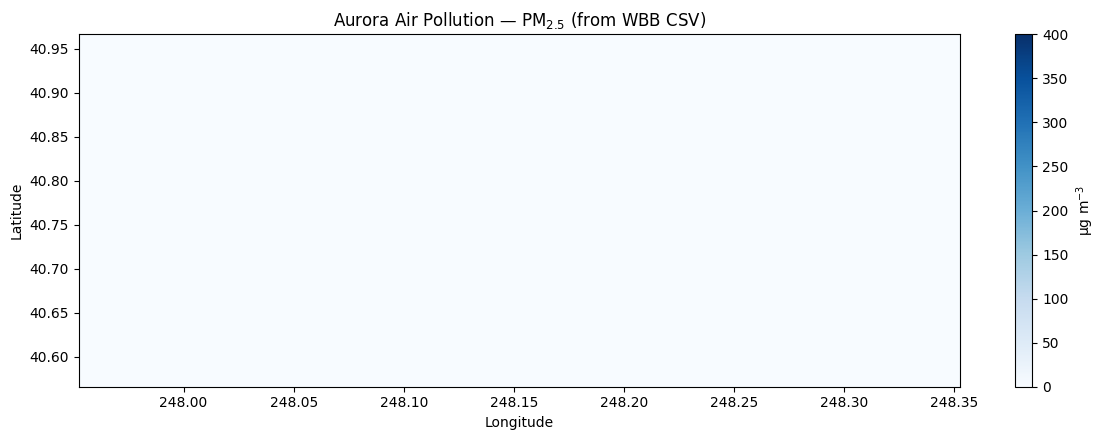

Saved: pm2p5_from_WBB_csv_aurora.csv
                       time  latitude   longitude  pm2p5_ugm3
0 2025-10-20 09:00:00-06:00  40.56623  247.952450 -205.359650
1 2025-10-20 09:00:00-06:00  40.56623  247.969841 -134.343063
2 2025-10-20 09:00:00-06:00  40.56623  247.987233 -157.547256
3 2025-10-20 09:00:00-06:00  40.56623  248.004624 -207.587631
4 2025-10-20 09:00:00-06:00  40.56623  248.022015 -142.719193


In [1]:
# WBB CSV -> Aurora Air Pollution (PM2.5) using your schema
# Columns used:
#  pressure_set_1 [Pa], air_temp_set_1 [C], relative_humidity_set_1 [%],
#  wind_speed_set_1 [m/s], wind_direction_set_1 [deg],
#  PM_25_concentration_set_1 [ug/m3] (fallback: PM_25_concentration_set_2)

import gc
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ CONFIG ------------------
CSV_PATH = Path("WBB.2025-10-21.csv")
STATIC_PATH = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# Station coords from header
STATION_LAT = 40.76623
STATION_LON = -111.84755

MIN_TILES   = 8
PAD_DEGREES = 0.2

# ------------------ helpers ------------------
def C_to_K(x): 
    return pd.to_numeric(x, errors="coerce") + 273.15

def wind_dir_speed_to_uv(drct_deg, spd_mps):
    d = np.deg2rad(pd.to_numeric(drct_deg, errors="coerce"))
    s = pd.to_numeric(spd_mps, errors="coerce")
    u = -s * np.sin(d)
    v = -s * np.cos(d)
    return u, v

def q_from_RH_TP(rh_pct, T_K, p_Pa):
    T_C = pd.to_numeric(T_K, errors="coerce") - 273.15
    e_s_hPa = 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))
    e_s_Pa  = e_s_hPa * 100.0
    rh = pd.to_numeric(rh_pct, errors="coerce") / 100.0
    p  = pd.to_numeric(p_Pa, errors="coerce")
    e  = np.clip(rh * e_s_Pa, 0.0, p * 0.99)
    w  = 0.622 * e / (p - e)
    return w / (1.0 + w)

def target_size(n, ps, min_tiles):
    return int(np.ceil(max(n, min_tiles*ps) / ps) * ps)

def nn_resample(arr, Ht, Wt):
    H0, W0 = arr.shape
    ii = np.rint(np.linspace(0, H0-1, Ht)).astype(int)
    jj = np.rint(np.linspace(0, W0-1, Wt)).astype(int)
    return arr[np.ix_(ii, jj)]

# ------------------ static ------------------
with open(STATIC_PATH, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ read CSV ------------------
df = pd.read_csv(
    CSV_PATH,
    comment="#",          # skip metadata header lines
    header=0,
    on_bad_lines="skip",  # tolerate truncated last line
)

# Drop the single "units" row (line 2) if present (pressure_set_1 == "Pascals")
if "pressure_set_1" in df.columns and isinstance(df["pressure_set_1"].iloc[0], str):
    if df["pressure_set_1"].iloc[0].strip().lower() == "pascals":
        df = df.iloc[1:].reset_index(drop=True)

# Parse time and sort
df["time"] = pd.to_datetime(df["Date_Time"], errors="coerce")
df = df[df["time"].notna()].copy().sort_values("time")

# Pick PM2.5 column
pm_candidates = ["PM_25_concentration_set_1", "PM_25_concentration_set_2"]
pm_col = next((c for c in pm_candidates if c in df.columns and pd.to_numeric(df[c], errors="coerce").notna().any()), None)

# Choose snapshot: max PM2.5 if available, else latest record
if pm_col is not None:
    df["PM25"] = pd.to_numeric(df[pm_col], errors="coerce")
    df["date"] = df["time"].dt.date
    date_with_max = df.groupby("date")["PM25"].max().idxmax()
    snap = df[df["date"] == date_with_max].copy()
    snap = snap.loc[snap["PM25"].idxmax()].to_frame().T
    reason = f"max {pm_col} on {date_with_max}"
else:
    snap = df.tail(1).copy()
    reason = "latest (no PM2.5 values present)"
snap_time = pd.to_datetime(snap["time"].iloc[0]).to_pydatetime()
t_prev = (pd.Timestamp(snap_time) - pd.Timedelta(hours=6)).to_pydatetime()
print(f"Using snapshot {snap_time} — {reason}")

# ------------------ map to Aurora inputs ------------------
# Pressure: prefer sea_level_pressure_set_1d if present, else pressure_set_1 (both are Pa in your file)
P_Pa = pd.to_numeric(
    snap.get("sea_level_pressure_set_1d", snap.get("pressure_set_1", 101325.0)),
    errors="coerce"
).fillna(101325.0)

# Temperature (K), RH (%), wind (m/s, deg)
T_K  = C_to_K(snap["air_temp_set_1"]).fillna(273.15)
RH   = pd.to_numeric(snap["relative_humidity_set_1"], errors="coerce").clip(0,100).fillna(50.0)
WSPD = pd.to_numeric(snap["wind_speed_set_1"], errors="coerce").clip(lower=0).fillna(0.0)
WDIR = pd.to_numeric(snap["wind_direction_set_1"], errors="coerce").fillna(0.0)

u10, v10 = wind_dir_speed_to_uv(WDIR, WSPD)
q = q_from_RH_TP(RH, T_K, P_Pa)

# PM2.5 input for the model (kg/m^3) from the chosen column; default 0 if none
pm2p5_in = pd.Series([0.0])
if pm_col is not None:
    pm2p5_in = pd.to_numeric(snap[pm_col], errors="coerce").fillna(0.0) * 1e-9

# ------------------ tiny grid around station ------------------
lat0 = float(STATION_LAT); lon0 = float(STATION_LON) % 360.0
lats = np.linspace(lat0 - PAD_DEGREES, lat0 + PAD_DEGREES, 5)
lons = np.linspace(lon0 - PAD_DEGREES, lon0 + PAD_DEGREES, 5)
H0, W0 = len(lats), len(lons)

def fill_tile(series_or_value):
    v = float(series_or_value.iloc[0]) if hasattr(series_or_value, "iloc") else float(series_or_value)
    return np.full((H0, W0), v, dtype=np.float32)

surf_native = {
    "2t":    fill_tile(T_K),
    "10u":   fill_tile(u10),
    "10v":   fill_tile(v10),
    "msl":   fill_tile(P_Pa),            # use station/sea-level pressure in Pa
    "pm2p5": fill_tile(pm2p5_in),        # kg/m^3
    "pm1":   np.zeros((H0,W0), np.float32),
    "pm10":  np.zeros((H0,W0), np.float32),
    "tcco":  np.zeros((H0,W0), np.float32),
    "tc_no": np.zeros((H0,W0), np.float32),
    "tcno2": np.zeros((H0,W0), np.float32),
    "gtco3": np.zeros((H0,W0), np.float32),
    "tcso2": np.zeros((H0,W0), np.float32),
}
atmo_native = {
    "t":  surf_native["2t"].copy(),
    "q":  fill_tile(q),
    "u":  surf_native["10u"].copy(),
    "v":  surf_native["10v"].copy(),
    "z":  np.zeros((H0,W0), np.float32),
    "co": np.zeros((H0,W0), np.float32),
    "no": np.zeros((H0,W0), np.float32),
    "no2":np.zeros((H0,W0), np.float32),
    "go3":np.zeros((H0,W0), np.float32),
    "so2":np.zeros((H0,W0), np.float32),
}

surf_native = xr.Dataset({k: xr.DataArray(v, dims=("latitude","longitude")) for k,v in surf_native.items()},
                         coords={"latitude": lats, "longitude": lons})
atmo_native = xr.Dataset({k: xr.DataArray(v, dims=("latitude","longitude")) for k,v in atmo_native.items()},
                         coords={"latitude": lats, "longitude": lons})

# ------------------ upsample to Aurora minimum ------------------
probe = AuroraAirPollution(); ps = int(probe.patch_size); del probe
Ht = target_size(H0, ps, MIN_TILES); Wt = target_size(W0, ps, MIN_TILES)

def upsample_ds(ds):
    out = {}
    for k, da in ds.data_vars.items():
        out[k] = xr.DataArray(nn_resample(da.values, Ht, Wt), dims=("latitude","longitude"))
    return xr.Dataset(out, coords={
        "latitude":  np.linspace(lats.min(), lats.max(), Ht),
        "longitude": np.linspace(lons.min(), lons.max(), Wt),
    })

surf_ds = upsample_ds(surf_native)
atmo_ds = upsample_ds(atmo_native)

# ------------------ run Aurora (tiled) ------------------
model = AuroraAirPollution(); model.load_checkpoint(); model.eval()
H, W = Ht, Wt
tile, overlap = 12*ps, 2*ps
step = tile - overlap
canvas = np.full((H, W), np.nan, dtype=np.float32)

def subset_static_tile(arr, ii, jj):
    if arr.ndim == 3: return arr[:, ii, jj]
    if arr.ndim == 2: return arr[ii, jj]
    return arr

gc.collect(); torch.cuda.empty_cache()

for i in range(0, H, step):
    for j in range(0, W, step):
        hi, wi = min(i+tile, H), min(j+tile, W)
        h = (hi - i) // ps * ps; w = (wi - j) // ps * ps
        if h < ps or w < ps: continue
        ii, jj = slice(i, i+h), slice(j, j+w)

        s_t = surf_ds.isel(latitude=ii, longitude=jj)
        a_t = atmo_ds.isel(latitude=ii, longitude=jj)

        def sarr(k):
            base = s_t[k].values.astype(np.float32)
            tw   = np.stack([base, base], axis=0)
            return torch.from_numpy(tw[None])
        def aarr(k):
            base = a_t[k].values.astype(np.float32)
            tw   = np.stack([base, base], axis=0)
            return torch.from_numpy(tw[None, :, None])

        surf_vars  = {k: sarr(k) for k in s_t.data_vars}
        atmos_vars = {k: aarr(k) for k in a_t.data_vars}

        stat_tile = {k: subset_static_tile(v, ii, jj) for k, v in static_vars_full.items() if k in ("lsm","z","slt")}
        static_tensors = {k: torch.from_numpy(np.ascontiguousarray(v)) for k, v in stat_tile.items()}

        # placeholder metadata (monotonic)
        lat_meta = torch.linspace( 90.0, -90.0, h, dtype=torch.float32)
        lon_meta = torch.linspace(  0.0, 360.0-1e-3, w, dtype=torch.float32)

        batch = Batch(
            surf_vars=surf_vars,
            static_vars=static_tensors,
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=lat_meta, lon=lon_meta,
                time=((pd.Timestamp(snap_time)-pd.Timedelta(hours=6)).to_pydatetime(), snap_time),
                atmos_levels=(1000,),
            ),
        )

        with torch.inference_mode():
            pred = model(batch)

        canvas[ii, jj] = pred.surf_vars["pm2p5"][0, 0].cpu().numpy().astype(np.float32)

        del s_t, a_t, stat_tile, static_tensors, batch, pred
        gc.collect()

# ------------------ plot + export ------------------
pm2p5_ugm3 = canvas / 1e-9
lat_vec, lon_vec = surf_ds.latitude.values, surf_ds.longitude.values

lat_plot = lat_vec.copy(); field = pm2p5_ugm3.copy()
if lat_plot[0] > lat_plot[-1]:
    lat_plot = lat_plot[::-1]; field = field[::-1, :]

extent = [lon_vec.min(), lon_vec.max(), lat_plot.min(), lat_plot.max()]
plt.figure(figsize=(12, 4.5))
plt.imshow(field, extent=extent, origin="lower", cmap="Blues", interpolation="bilinear",
           vmin=0, vmax=400, aspect="auto")
plt.title("Aurora Air Pollution — PM$_{2.5}$ (from WBB CSV)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label="µg m$^{-3}$")
plt.tight_layout(); plt.show()

LON2D, LAT2D = np.meshgrid(lon_vec, lat_vec)
df_pred = pd.DataFrame({
    "time":       snap_time,
    "latitude":   LAT2D.ravel(),
    "longitude":  LON2D.ravel(),
    "pm2p5_ugm3": pm2p5_ugm3.ravel(),
})
df_pred = df_pred[np.isfinite(df_pred["pm2p5_ugm3"])].reset_index(drop=True)
df_pred.to_csv("pm2p5_from_WBB_csv_aurora.csv", index=False)
print("Saved: pm2p5_from_WBB_csv_aurora.csv")
print(df_pred.head())


In [2]:
# WBB CSV -> 12h (per-minute) PM2.5 forecast at station using Aurora (single-point AR loop)

import gc
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ CONFIG ------------------
CSV_PATH = Path("WBB.2025-10-21.csv")
STATIC_PATH = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# Station coords from header
STATION_LAT = 40.76623
STATION_LON = -111.84755

MIN_TILES   = 8        # min tiles when upsampling to meet Aurora's min spatial size
PAD_DEGREES = 0.2      # native tiny grid pad before upsampling
FORECAST_MINUTES = 24 * 60
DT = pd.Timedelta(minutes=1)

# ------------------ helpers ------------------
def C_to_K(x): 
    return pd.to_numeric(x, errors="coerce") + 273.15

def wind_dir_speed_to_uv(drct_deg, spd_mps):
    d = np.deg2rad(pd.to_numeric(drct_deg, errors="coerce"))
    s = pd.to_numeric(spd_mps, errors="coerce")
    u = -s * np.sin(d)
    v = -s * np.cos(d)
    return u, v

def q_from_RH_TP(rh_pct, T_K, p_Pa):
    T_C = pd.to_numeric(T_K, errors="coerce") - 273.15
    e_s_hPa = 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))
    e_s_Pa  = e_s_hPa * 100.0
    rh = pd.to_numeric(rh_pct, errors="coerce") / 100.0
    p  = pd.to_numeric(p_Pa, errors="coerce")
    e  = np.clip(rh * e_s_Pa, 0.0, p * 0.99)
    w  = 0.622 * e / (p - e)
    return w / (1.0 + w)

def target_size(n, ps, min_tiles):
    return int(np.ceil(max(n, min_tiles*ps) / ps) * ps)

def nn_resample(arr, Ht, Wt):
    H0, W0 = arr.shape
    ii = np.rint(np.linspace(0, H0-1, Ht)).astype(int)
    jj = np.rint(np.linspace(0, W0-1, Wt)).astype(int)
    return arr[np.ix_(ii, jj)]

# ------------------ static ------------------
with open(STATIC_PATH, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ read CSV ------------------
df = pd.read_csv(
    CSV_PATH,
    comment="#",          # skip metadata header lines
    header=0,
    on_bad_lines="skip",  # tolerate truncated last line
)

# Drop the single "units" row (line 2) if present (pressure_set_1 == "Pascals")
if "pressure_set_1" in df.columns and isinstance(df["pressure_set_1"].iloc[0], str):
    if df["pressure_set_1"].iloc[0].strip().lower() == "pascals":
        df = df.iloc[1:].reset_index(drop=True)

# Parse time and sort
df["time"] = pd.to_datetime(df["Date_Time"], errors="coerce")
df = df[df["time"].notna()].copy().sort_values("time")

# Pick PM2.5 column
pm_candidates = ["PM_25_concentration_set_1", "PM_25_concentration_set_2"]
pm_col = next((c for c in pm_candidates if c in df.columns and pd.to_numeric(df[c], errors="coerce").notna().any()), None)

# Choose snapshot: latest valid PM2.5 (or latest record if none)
if pm_col is not None:
    df["PM25"] = pd.to_numeric(df[pm_col], errors="coerce")
    snap = df[df["PM25"].notna()].tail(1).copy()
    reason = f"latest valid PM2.5 ({pm_col})"
else:
    snap = df.tail(1).copy()
    reason = "latest (no PM2.5 values present — starting from 0)"
snap_time = pd.to_datetime(snap["time"].iloc[0]).to_pydatetime()
t_prev = (pd.Timestamp(snap_time) - pd.Timedelta(hours=6)).to_pydatetime()
print(f"Using snapshot {snap_time} — {reason}")

# ------------------ map to Aurora inputs ------------------
# Pressure: prefer sea_level_pressure_set_1d if present, else station pressure
P_Pa = pd.to_numeric(
    snap.get("sea_level_pressure_set_1d", snap.get("pressure_set_1", 101325.0)),
    errors="coerce"
).fillna(101325.0)

# Temperature (K), RH (%), wind (m/s, deg)
T_K  = C_to_K(snap["air_temp_set_1"]).fillna(273.15)
RH   = pd.to_numeric(snap["relative_humidity_set_1"], errors="coerce").clip(0,100).fillna(50.0)
WSPD = pd.to_numeric(snap["wind_speed_set_1"], errors="coerce").clip(lower=0).fillna(0.0)
WDIR = pd.to_numeric(snap["wind_direction_set_1"], errors="coerce").fillna(0.0)

u10, v10 = wind_dir_speed_to_uv(WDIR, WSPD)
q = q_from_RH_TP(RH, T_K, P_Pa)

# PM2.5 input for the model (kg/m^3) from the chosen column; default 0 if none
pm2p5_in = pd.Series([0.0])
if pm_col is not None:
    pm2p5_in = pd.to_numeric(snap[pm_col], errors="coerce").fillna(0.0) * 1e-9  # µg/m³ -> kg/m³

# ------------------ tiny grid around station ------------------
lat0 = float(STATION_LAT)
lon0 = float(STATION_LON) % 360.0
lats = np.linspace(lat0 - PAD_DEGREES, lat0 + PAD_DEGREES, 5)
lons = np.linspace(lon0 - PAD_DEGREES, lon0 + PAD_DEGREES, 5)
H0, W0 = len(lats), len(lons)

def fill_tile(series_or_value):
    v = float(series_or_value.iloc[0]) if hasattr(series_or_value, "iloc") else float(series_or_value)
    return np.full((H0, W0), v, dtype=np.float32)

surf_native = {
    "2t":    fill_tile(T_K),     # K
    "10u":   fill_tile(u10),     # m/s
    "10v":   fill_tile(v10),     # m/s
    "msl":   fill_tile(P_Pa),    # Pa
    "pm2p5": fill_tile(pm2p5_in),# kg/m^3
    "pm1":   np.zeros((H0,W0), np.float32),
    "pm10":  np.zeros((H0,W0), np.float32),
    "tcco":  np.zeros((H0,W0), np.float32),
    "tc_no": np.zeros((H0,W0), np.float32),
    "tcno2": np.zeros((H0,W0), np.float32),
    "gtco3": np.zeros((H0,W0), np.float32),
    "tcso2": np.zeros((H0,W0), np.float32),
}
atmo_native = {
    "t":  surf_native["2t"].copy(),
    "q":  fill_tile(q),
    "u":  surf_native["10u"].copy(),
    "v":  surf_native["10v"].copy(),
    "z":  np.zeros((H0,W0), np.float32),
    "co": np.zeros((H0,W0), np.float32),
    "no": np.zeros((H0,W0), np.float32),
    "no2":np.zeros((H0,W0), np.float32),
    "go3":np.zeros((H0,W0), np.float32),
    "so2":np.zeros((H0,W0), np.float32),
}

surf_native = xr.Dataset({k: xr.DataArray(v, dims=("latitude","longitude")) for k,v in surf_native.items()},
                         coords={"latitude": lats, "longitude": lons})
atmo_native = xr.Dataset({k: xr.DataArray(v, dims=("latitude","longitude")) for k,v in atmo_native.items()},
                         coords={"latitude": lats, "longitude": lons})

# ------------------ upsample to Aurora minimum ------------------
probe = AuroraAirPollution()
ps = int(probe.patch_size)   # e.g., 16
del probe

Ht = target_size(H0, ps, MIN_TILES)   # e.g., 128
Wt = target_size(W0, ps, MIN_TILES)   # e.g., 128

def upsample_ds(ds):
    out = {}
    for k, da in ds.data_vars.items():
        out[k] = xr.DataArray(nn_resample(da.values, Ht, Wt), dims=("latitude","longitude"))
    return xr.Dataset(out, coords={
        "latitude":  np.linspace(lats.min(), lats.max(), Ht),
        "longitude": np.linspace(lons.min(), lons.max(), Wt),
    })

surf_ds = upsample_ds(surf_native)
atmo_ds = upsample_ds(atmo_native)

# ------------------ choose full grid (robust: >= 2x2 patches) ------------------
lat_vec = surf_ds.latitude.values
lon_vec = surf_ds.longitude.values

# nearest cell to the station on the upsampled grid
i_pt = int(np.argmin(np.abs(lat_vec - lat0)))
j_pt = int(np.argmin(np.abs(lon_vec - lon0)))

# Use the whole upsampled grid — ensures multiples of patch size and H_patches, W_patches >= 2
h = int(surf_ds.sizes["latitude"])
w = int(surf_ds.sizes["longitude"])
assert (h % ps) == 0 and (w % ps) == 0, f"Grid must be multiples of patch size: h={h}, w={w}, ps={ps}"
assert (h // ps) >= 2 and (w // ps) >= 2, f"Grid too small: h={h}, w={w}, ps={ps}"

# ------------------ build tensors for the full grid ------------------
def subset_static_full(arr):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, :h, :w]
    if arr.ndim == 2:  # (H,W)
        return arr[:h, :w]
    raise ValueError("Unexpected static array rank")

static_full = {k: subset_static_full(v) for k, v in static_vars_full.items() if k in ("lsm", "z", "slt")}
static_tensors = {k: torch.from_numpy(np.ascontiguousarray(v)).float() for k, v in static_full.items()}

def tens_surf(da: xr.DataArray) -> torch.Tensor:
    base = np.ascontiguousarray(da.values.astype(np.float32))     # [H, W]
    tw   = np.stack([base, base], axis=0)                         # [T=2, H, W]
    return torch.from_numpy(tw[None])                             # [B=1, T=2, H, W]

def tens_atmo(da: xr.DataArray) -> torch.Tensor:
    base = np.ascontiguousarray(da.values.astype(np.float32))     # [H, W]
    tw   = np.stack([base, base], axis=0)                         # [T=2, H, W]
    tw   = tw[:, None]                                            # [T=2, L=1, H, W]
    return torch.from_numpy(tw[None])                             # [B=1, T=2, L=1, H, W]

surf_tensors = {k: tens_surf(surf_ds[k]) for k in surf_ds.data_vars}
atmo_tensors = {k: tens_atmo(atmo_ds[k]) for k in atmo_ds.data_vars}

# ------------------ model ------------------
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()

# ------------------ autoregressive minute-by-minute loop ------------------
times = []
vals_ug = []

t0_prev = t_prev
t0_cur  = snap_time

for step in range(12 * 60):  # 12 hours * 60 minutes
    # advance time window by 1 minute
    t1_prev = (pd.Timestamp(t0_prev) + pd.Timedelta(minutes=1)).to_pydatetime()
    t1_cur  = (pd.Timestamp(t0_cur)  + pd.Timedelta(minutes=1)).to_pydatetime()

    # metadata must match current grid (h, w)
    lat_meta = torch.linspace(90.0, -90.0, h, dtype=torch.float32)
    lon_meta = torch.linspace(0.0, 360.0 - 1e-3, w, dtype=torch.float32)

    batch = Batch(
        surf_vars=surf_tensors,
        static_vars=static_tensors,
        atmos_vars=atmo_tensors,
        metadata=Metadata(
            lat=lat_meta,
            lon=lon_meta,
            time=(t1_prev, t1_cur),
            atmos_levels=(1000,),  # pseudo single level
            # rollout_step=1,       # uncomment if required by your aurora version
        ),
    )

    with torch.inference_mode():
        pred = model(batch)

    # predicted pm2p5 tile: [B, T, H, W]; take the "current" frame (index 0)
    pm2p5_grid = pred.surf_vars["pm2p5"][0, 0].cpu().numpy().astype(np.float32)  # kg/m^3
    pm2p5_point_kg = float(pm2p5_grid[i_pt, j_pt])
    pm2p5_point_ug = pm2p5_point_kg / 1e-9  # kg/m^3 -> µg/m^3

    times.append(t1_cur)
    vals_ug.append(pm2p5_point_ug)

    # AR update: feed the predicted grid back as BOTH frames for the next step
    pm2p5_next = torch.from_numpy(np.stack([pm2p5_grid, pm2p5_grid], axis=0)[None])  # [1,2,H,W]
    surf_tensors["pm2p5"] = pm2p5_next

    # advance times
    t0_prev, t0_cur = t1_prev, t1_cur

    if (step % 50) == 0:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ------------------ save CSV ------------------
out = pd.DataFrame({
    "time": times,
    "latitude": STATION_LAT,
    "longitude": STATION_LON,
    "pm2p5_ugm3": vals_ug,
})
out.to_csv("pm25_forecast_12h_WBB.csv", index=False)
print("Saved: pm25_forecast_12h_WBB.csv")
print(out.head())

# ------------------ plot ------------------
plt.figure(figsize=(12, 4))
plt.plot(out["time"], out["pm2p5_ugm3"])
plt.title("PM$_{2.5}$ forecast (12h, 1-min steps) — WBB station")
plt.xlabel("Time")
plt.ylabel("PM$_{2.5}$ (µg m$^{-3}$)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_689186/3560250434.py:59: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Using snapshot 2025-10-21 06:00:00-06:00 — latest valid PM2.5 (PM_25_concentration_set_1)


KeyboardInterrupt: 

/tmp/ipykernel_689186/321733919.py:59: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Using snapshot 2025-10-21 06:00:00-06:00 — latest valid PM2.5 (PM_25_concentration_set_1)
Saved: pm25_forecast_24h_WBB.csv
                       time  latitude  longitude  pm2p5_ugm3
0 2025-10-21 06:01:00-06:00  40.76623 -111.84755 -110.242361
1 2025-10-21 06:02:00-06:00  40.76623 -111.84755  -80.749906
2 2025-10-21 06:03:00-06:00  40.76623 -111.84755  -89.580958
3 2025-10-21 06:04:00-06:00  40.76623 -111.84755  -86.866230
4 2025-10-21 06:05:00-06:00  40.76623 -111.84755  -87.527361


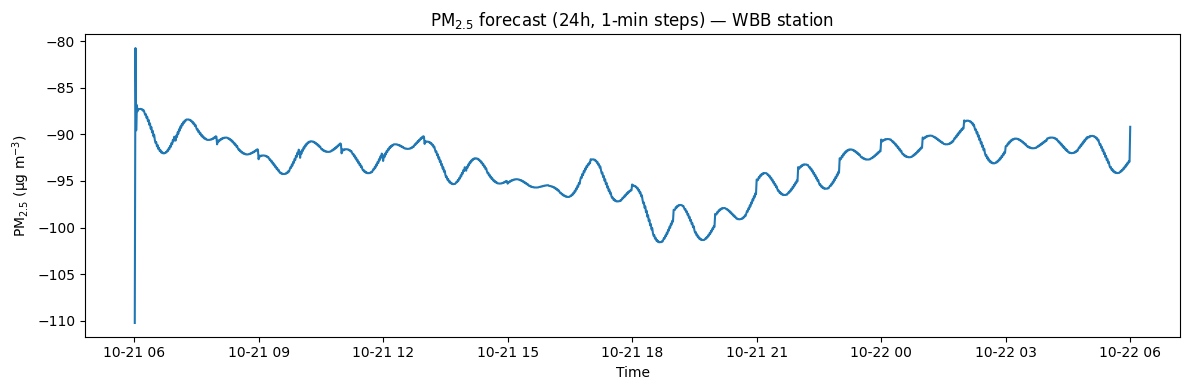

In [5]:
# WBB CSV -> 12h (per-minute) PM2.5 forecast at station using Aurora (single-point AR loop)

import gc
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from aurora import Batch, Metadata, AuroraAirPollution

# ------------------ CONFIG ------------------
CSV_PATH = Path("WBB.2025-10-21.csv")
STATIC_PATH = hf_hub_download("microsoft/aurora", "aurora-0.4-air-pollution-static.pickle")

# Station coords from header
STATION_LAT = 40.76623
STATION_LON = -111.84755

MIN_TILES   = 8        # min tiles when upsampling to meet Aurora's min spatial size
PAD_DEGREES = 0.2      # native tiny grid pad before upsampling
FORECAST_MINUTES = 12 * 60
DT = pd.Timedelta(minutes=1)

# ------------------ helpers ------------------
def C_to_K(x): 
    return pd.to_numeric(x, errors="coerce") + 273.15

def wind_dir_speed_to_uv(drct_deg, spd_mps):
    d = np.deg2rad(pd.to_numeric(drct_deg, errors="coerce"))
    s = pd.to_numeric(spd_mps, errors="coerce")
    u = -s * np.sin(d)
    v = -s * np.cos(d)
    return u, v

def q_from_RH_TP(rh_pct, T_K, p_Pa):
    T_C = pd.to_numeric(T_K, errors="coerce") - 273.15
    e_s_hPa = 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))
    e_s_Pa  = e_s_hPa * 100.0
    rh = pd.to_numeric(rh_pct, errors="coerce") / 100.0
    p  = pd.to_numeric(p_Pa, errors="coerce")
    e  = np.clip(rh * e_s_Pa, 0.0, p * 0.99)
    w  = 0.622 * e / (p - e)
    return w / (1.0 + w)

def target_size(n, ps, min_tiles):
    return int(np.ceil(max(n, min_tiles*ps) / ps) * ps)

def nn_resample(arr, Ht, Wt):
    H0, W0 = arr.shape
    ii = np.rint(np.linspace(0, H0-1, Ht)).astype(int)
    jj = np.rint(np.linspace(0, W0-1, Wt)).astype(int)
    return arr[np.ix_(ii, jj)]

# ------------------ static ------------------
with open(STATIC_PATH, "rb") as f:
    static_vars_full = pickle.load(f)

# ------------------ read CSV ------------------
df = pd.read_csv(
    CSV_PATH,
    comment="#",          # skip metadata header lines
    header=0,
    on_bad_lines="skip",  # tolerate truncated last line
)

# Drop the single "units" row (line 2) if present (pressure_set_1 == "Pascals")
if "pressure_set_1" in df.columns and isinstance(df["pressure_set_1"].iloc[0], str):
    if df["pressure_set_1"].iloc[0].strip().lower() == "pascals":
        df = df.iloc[1:].reset_index(drop=True)

# Parse time and sort
df["time"] = pd.to_datetime(df["Date_Time"], errors="coerce")
df = df[df["time"].notna()].copy().sort_values("time")

# Pick PM2.5 column
pm_candidates = ["PM_25_concentration_set_1", "PM_25_concentration_set_2"]
pm_col = next((c for c in pm_candidates if c in df.columns and pd.to_numeric(df[c], errors="coerce").notna().any()), None)

# Choose snapshot: latest valid PM2.5 (or latest record if none)
if pm_col is not None:
    df["PM25"] = pd.to_numeric(df[pm_col], errors="coerce")
    snap = df[df["PM25"].notna()].tail(1).copy()
    reason = f"latest valid PM2.5 ({pm_col})"
else:
    snap = df.tail(1).copy()
    reason = "latest (no PM2.5 values present — starting from 0)"
snap_time = pd.to_datetime(snap["time"].iloc[0]).to_pydatetime()
t_prev = (pd.Timestamp(snap_time) - pd.Timedelta(hours=6)).to_pydatetime()
print(f"Using snapshot {snap_time} — {reason}")

# ------------------ map to Aurora inputs ------------------
# Pressure: prefer sea_level_pressure_set_1d if present, else station pressure
P_Pa = pd.to_numeric(
    snap.get("sea_level_pressure_set_1d", snap.get("pressure_set_1", 101325.0)),
    errors="coerce"
).fillna(101325.0)

# Temperature (K), RH (%), wind (m/s, deg)
T_K  = C_to_K(snap["air_temp_set_1"]).fillna(273.15)
RH   = pd.to_numeric(snap["relative_humidity_set_1"], errors="coerce").clip(0,100).fillna(50.0)
WSPD = pd.to_numeric(snap["wind_speed_set_1"], errors="coerce").clip(lower=0).fillna(0.0)
WDIR = pd.to_numeric(snap["wind_direction_set_1"], errors="coerce").fillna(0.0)

u10, v10 = wind_dir_speed_to_uv(WDIR, WSPD)
q = q_from_RH_TP(RH, T_K, P_Pa)

# PM2.5 input for the model (kg/m^3) from the chosen column; default 0 if none
pm2p5_in = pd.Series([0.0])
if pm_col is not None:
    pm2p5_in = pd.to_numeric(snap[pm_col], errors="coerce").fillna(0.0) * 1e-9  # µg/m³ -> kg/m³

# ------------------ tiny grid around station ------------------
lat0 = float(STATION_LAT)
lon0 = float(STATION_LON) % 360.0
lats = np.linspace(lat0 - PAD_DEGREES, lat0 + PAD_DEGREES, 5)
lons = np.linspace(lon0 - PAD_DEGREES, lon0 + PAD_DEGREES, 5)
H0, W0 = len(lats), len(lons)

def fill_tile(series_or_value):
    v = float(series_or_value.iloc[0]) if hasattr(series_or_value, "iloc") else float(series_or_value)
    return np.full((H0, W0), v, dtype=np.float32)

surf_native = {
    "2t":    fill_tile(T_K),     # K
    "10u":   fill_tile(u10),     # m/s
    "10v":   fill_tile(v10),     # m/s
    "msl":   fill_tile(P_Pa),    # Pa
    "pm2p5": fill_tile(pm2p5_in),# kg/m^3
    "pm1":   np.zeros((H0,W0), np.float32),
    "pm10":  np.zeros((H0,W0), np.float32),
    "tcco":  np.zeros((H0,W0), np.float32),
    "tc_no": np.zeros((H0,W0), np.float32),
    "tcno2": np.zeros((H0,W0), np.float32),
    "gtco3": np.zeros((H0,W0), np.float32),
    "tcso2": np.zeros((H0,W0), np.float32),
}
atmo_native = {
    "t":  surf_native["2t"].copy(),
    "q":  fill_tile(q),
    "u":  surf_native["10u"].copy(),
    "v":  surf_native["10v"].copy(),
    "z":  np.zeros((H0,W0), np.float32),
    "co": np.zeros((H0,W0), np.float32),
    "no": np.zeros((H0,W0), np.float32),
    "no2":np.zeros((H0,W0), np.float32),
    "go3":np.zeros((H0,W0), np.float32),
    "so2":np.zeros((H0,W0), np.float32),
}

surf_native = xr.Dataset({k: xr.DataArray(v, dims=("latitude","longitude")) for k,v in surf_native.items()},
                         coords={"latitude": lats, "longitude": lons})
atmo_native = xr.Dataset({k: xr.DataArray(v, dims=("latitude","longitude")) for k,v in atmo_native.items()},
                         coords={"latitude": lats, "longitude": lons})

# ------------------ upsample to Aurora minimum ------------------
probe = AuroraAirPollution()
ps = int(probe.patch_size)   # e.g., 16
del probe

Ht = target_size(H0, ps, MIN_TILES)   # e.g., 128
Wt = target_size(W0, ps, MIN_TILES)   # e.g., 128

def upsample_ds(ds):
    out = {}
    for k, da in ds.data_vars.items():
        out[k] = xr.DataArray(nn_resample(da.values, Ht, Wt), dims=("latitude","longitude"))
    return xr.Dataset(out, coords={
        "latitude":  np.linspace(lats.min(), lats.max(), Ht),
        "longitude": np.linspace(lons.min(), lons.max(), Wt),
    })

surf_ds = upsample_ds(surf_native)
atmo_ds = upsample_ds(atmo_native)

# ------------------ choose full grid (robust: >= 2x2 patches) ------------------
lat_vec = surf_ds.latitude.values
lon_vec = surf_ds.longitude.values

# nearest cell to the station on the upsampled grid
i_pt = int(np.argmin(np.abs(lat_vec - lat0)))
j_pt = int(np.argmin(np.abs(lon_vec - lon0)))

# Use the whole upsampled grid — ensures multiples of patch size and H_patches, W_patches >= 2
h = int(surf_ds.sizes["latitude"])
w = int(surf_ds.sizes["longitude"])
assert (h % ps) == 0 and (w % ps) == 0, f"Grid must be multiples of patch size: h={h}, w={w}, ps={ps}"
assert (h // ps) >= 2 and (w // ps) >= 2, f"Grid too small: h={h}, w={w}, ps={ps}"

# ------------------ build tensors for the full grid ------------------
def subset_static_full(arr):
    if arr.ndim == 3:  # (C,H,W)
        return arr[:, :h, :w]
    if arr.ndim == 2:  # (H,W)
        return arr[:h, :w]
    raise ValueError("Unexpected static array rank")

static_full = {k: subset_static_full(v) for k, v in static_vars_full.items() if k in ("lsm", "z", "slt")}
static_tensors = {k: torch.from_numpy(np.ascontiguousarray(v)).float() for k, v in static_full.items()}

def tens_surf(da: xr.DataArray) -> torch.Tensor:
    base = np.ascontiguousarray(da.values.astype(np.float32))     # [H, W]
    tw   = np.stack([base, base], axis=0)                         # [T=2, H, W]
    return torch.from_numpy(tw[None])                             # [B=1, T=2, H, W]

def tens_atmo(da: xr.DataArray) -> torch.Tensor:
    base = np.ascontiguousarray(da.values.astype(np.float32))     # [H, W]
    tw   = np.stack([base, base], axis=0)                         # [T=2, H, W]
    tw   = tw[:, None]                                            # [T=2, L=1, H, W]
    return torch.from_numpy(tw[None])                             # [B=1, T=2, L=1, H, W]

surf_tensors = {k: tens_surf(surf_ds[k]) for k in surf_ds.data_vars}
atmo_tensors = {k: tens_atmo(atmo_ds[k]) for k in atmo_ds.data_vars}

# ------------------ model ------------------
model = AuroraAirPollution()
model.load_checkpoint()
model.eval()

# ------------------ autoregressive minute-by-minute loop ------------------
times = []
vals_ug = []

t0_prev = t_prev
t0_cur  = snap_time

for step in range(24 * 60):  # 12 hours * 60 minutes
    # advance time window by 1 minute
    t1_prev = (pd.Timestamp(t0_prev) + pd.Timedelta(minutes=1)).to_pydatetime()
    t1_cur  = (pd.Timestamp(t0_cur)  + pd.Timedelta(minutes=1)).to_pydatetime()

    # metadata must match current grid (h, w)
    lat_meta = torch.linspace(90.0, -90.0, h, dtype=torch.float32)
    lon_meta = torch.linspace(0.0, 360.0 - 1e-3, w, dtype=torch.float32)

    batch = Batch(
        surf_vars=surf_tensors,
        static_vars=static_tensors,
        atmos_vars=atmo_tensors,
        metadata=Metadata(
            lat=lat_meta,
            lon=lon_meta,
            time=(t1_prev, t1_cur),
            atmos_levels=(1000,),  # pseudo single level
            # rollout_step=1,       # uncomment if required by your aurora version
        ),
    )

    with torch.inference_mode():
        pred = model(batch)

    # predicted pm2p5 tile: [B, T, H, W]; take the "current" frame (index 0)
    pm2p5_grid = pred.surf_vars["pm2p5"][0, 0].cpu().numpy().astype(np.float32)  # kg/m^3
    pm2p5_point_kg = float(pm2p5_grid[i_pt, j_pt])
    pm2p5_point_ug = pm2p5_point_kg / 1e-9  # kg/m^3 -> µg/m^3

    times.append(t1_cur)
    vals_ug.append(pm2p5_point_ug)

    # AR update: feed the predicted grid back as BOTH frames for the next step
    pm2p5_next = torch.from_numpy(np.stack([pm2p5_grid, pm2p5_grid], axis=0)[None])  # [1,2,H,W]
    surf_tensors["pm2p5"] = pm2p5_next

    # advance times
    t0_prev, t0_cur = t1_prev, t1_cur

    if (step % 50) == 0:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ------------------ save CSV ------------------
out = pd.DataFrame({
    "time": times,
    "latitude": STATION_LAT,
    "longitude": STATION_LON,
    "pm2p5_ugm3": vals_ug,
})
out.to_csv("pm25_forecast_24h_WBB.csv", index=False)
print("Saved: pm25_forecast_24h_WBB.csv")
print(out.head())

# ------------------ plot ------------------
plt.figure(figsize=(12, 4))
plt.plot(out["time"], out["pm2p5_ugm3"])
plt.title("PM$_{2.5}$ forecast (24h, 1-min steps) — WBB station")
plt.xlabel("Time")
plt.ylabel("PM$_{2.5}$ (µg m$^{-3}$)")
plt.tight_layout()
plt.show()


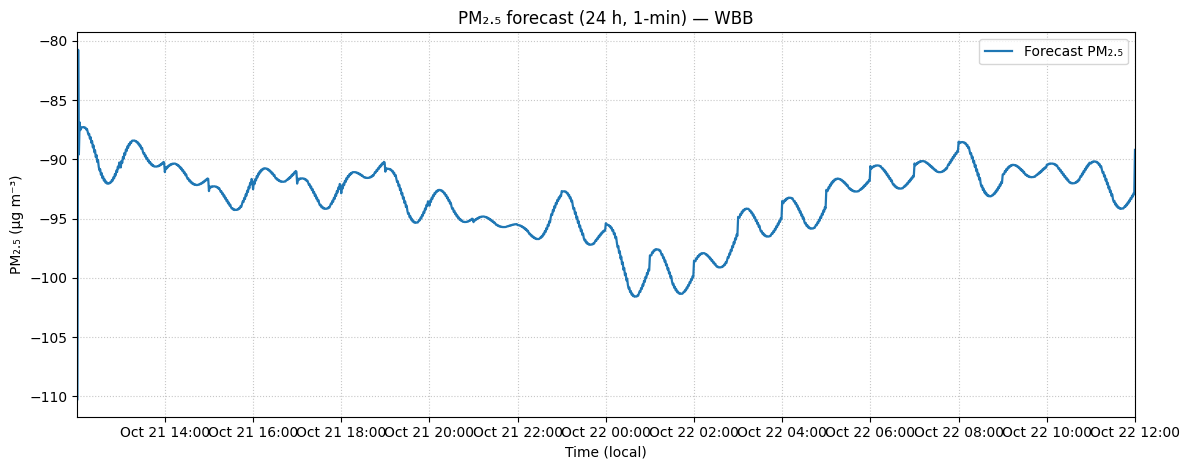

In [6]:
# Plot PM2.5 forecast (reads pm25_forecast_24h_WBB.csv)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

INPUT_CSV = Path("pm25_forecast_24h_WBB.csv")

df = pd.read_csv(INPUT_CSV)
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"]).sort_values("time")

fig, ax = plt.subplots(figsize=(12, 4.8))
ax.plot(df["time"], df["pm2p5_ugm3"], linewidth=1.6, label="Forecast PM₂.₅")

# Explicitly show full window (prevents axis from starting at 00:00)
ax.set_xlim(df["time"].min(), df["time"].max())

# Clearer ticks: every 2 hours with date+time
locator = mdates.HourLocator(interval=2)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %H:%M"))

ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
ax.set_title("PM₂.₅ forecast (24 h, 1-min) — WBB", fontsize=12)
ax.set_xlabel("Time (local)")
ax.set_ylabel("PM₂.₅ (µg m⁻³)")
ax.legend()
plt.tight_layout()
plt.show()

Saved: WBB.2025-10-22_observed_pm25_avg_dropped_zero.csv | Rows: 289 | Using: avg(set_1, set_2)
                  time  latitude  longitude  pm25_ugm3
0  2025-10-21 06:00:00  40.76623 -111.84755       1.09
5  2025-10-21 06:05:00  40.76623 -111.84755       1.12
10 2025-10-21 06:10:00  40.76623 -111.84755       1.24
15 2025-10-21 06:15:00  40.76623 -111.84755       1.11
20 2025-10-21 06:20:00  40.76623 -111.84755       1.14


/tmp/ipykernel_689186/3047386112.py:36: RuntimeWarning: Mean of empty slice
  pm = np.nanmean(np.vstack([s1.values, s2.values]), axis=0)


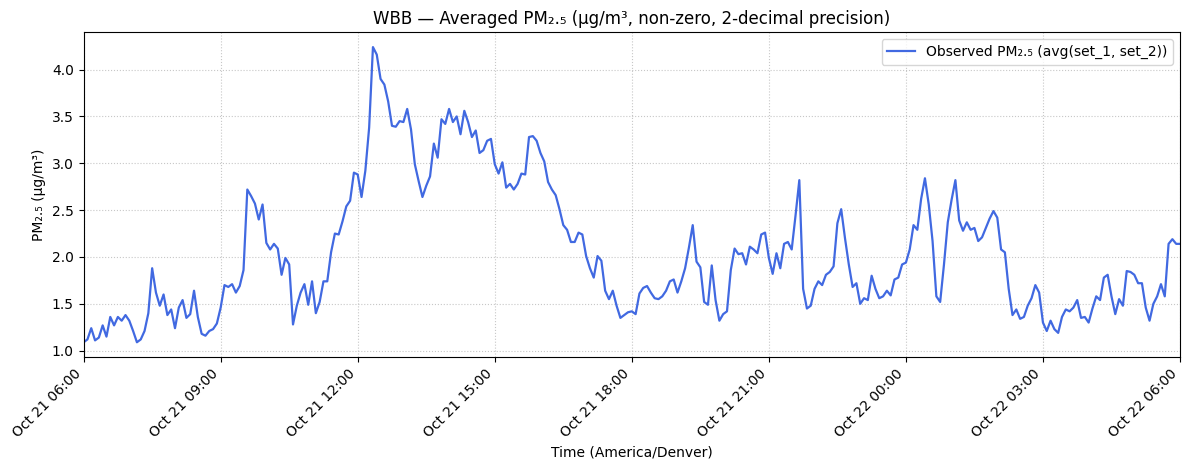

In [14]:
# Build compact CSV with time, latitude, longitude, and averaged PM2.5 (rounded to 2 decimals)
# Drops 0.0 PM2.5 values and improves time-axis readability in the plot

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

CSV_IN   = Path("WBB.2025-10-22.csv")
CSV_OUT  = Path("WBB.2025-10-22_observed_pm25_avg_dropped_zero.csv")
LOCAL_TZ = "America/Denver"

# Station coordinates
STATION_LAT = 40.76623
STATION_LON = -111.84755

# ---- Load ----
df = pd.read_csv(CSV_IN, comment="#", header=0, on_bad_lines="skip")

# Drop the single units row if present (pressure_set_1 == "Pascals")
if "pressure_set_1" in df.columns and isinstance(df["pressure_set_1"].iloc[0], str):
    if df["pressure_set_1"].iloc[0].strip().lower() == "pascals":
        df = df.iloc[1:].reset_index(drop=True)

# ---- Time handling ----
t_utc = pd.to_datetime(df["Date_Time"], errors="coerce", utc=True)
df["time"] = t_utc.dt.tz_convert(LOCAL_TZ).dt.tz_localize(None)
df = df.dropna(subset=["time"]).sort_values("time")

# ---- PM2.5 averaging ----
s1 = pd.to_numeric(df.get("PM_25_concentration_set_1"), errors="coerce") if "PM_25_concentration_set_1" in df.columns else None
s2 = pd.to_numeric(df.get("PM_25_concentration_set_2"), errors="coerce") if "PM_25_concentration_set_2" in df.columns else None

if s1 is not None and s2 is not None:
    pm = np.nanmean(np.vstack([s1.values, s2.values]), axis=0)
    used_label = "avg(set_1, set_2)"
elif s1 is not None:
    pm = s1.values
    used_label = "set_1"
elif s2 is not None:
    pm = s2.values
    used_label = "set_2"
else:
    pm = np.zeros(len(df))
    used_label = "none (zeros)"

pm = np.where(np.isfinite(pm), pm, 0.0)
pm = np.round(pm, 2)
df["pm25_ugm3"] = pm

# ---- Drop zeros ----
df = df[df["pm25_ugm3"] > 0].copy()

# ---- Keep only required columns ----
out = df.loc[:, ["time"]].copy()
out["latitude"]  = STATION_LAT
out["longitude"] = STATION_LON
out["pm25_ugm3"] = df["pm25_ugm3"].astype(float)

# ---- Save ----
out.to_csv(CSV_OUT, index=False)
print(f"Saved: {CSV_OUT} | Rows: {len(out)} | Using: {used_label}")
print(out.head())

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12, 4.8))
ax.plot(out["time"], out["pm25_ugm3"], color="royalblue", linewidth=1.6, label=f"Observed PM₂.₅ ({used_label})")

# Format x-axis: fewer ticks and rotated labels
locator = mdates.HourLocator(interval=3)  # every 3 hours
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %H:%M"))
plt.xticks(rotation=45, ha="right")

ax.set_xlim(out["time"].min(), out["time"].max())
ax.grid(True, linestyle=":", alpha=0.7)
ax.set_title("WBB — Averaged PM₂.₅ (µg/m³, non-zero, 2-decimal precision)", fontsize=12)
ax.set_xlabel("Time (America/Denver)")
ax.set_ylabel("PM₂.₅ (µg/m³)")
ax.legend()
plt.tight_layout()
plt.show()
